<a href="https://colab.research.google.com/github/kirwarobert/cnn/blob/main/Hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

# install missing packages
try:
  from skopt import BayesSearchCV
except ModuleNotFoundError:
    import subprocess
    subprocess.check_call(["pip", "install", "scikit-optimize"])
    from skopt import BayesSearchCV

In [ ]:
try:
  import shap
except ModuleNotFoundError:
  import subprocess
  subprocess.check_call(["pip", "install", "shap"])
  import shap


In [ ]:
try:
  import lime
  from lime.lime_tabular import LimeTabularExplainer
except ModuleNotFoundError:
  import subprocess
  subprocess.check_call(["pip", "install", "lime"])
  import lime
  from lime.lime_tabular import LimeTabularExplainer

In [ ]:
# GENERATE SYNTETIC DATA SET
np.random.seed(42)
n_samples=500
n_features=10
X = np.random.rand(n_samples, n_features) * 10
y=np.random.choice([0,1], size=n_samples)

In [ ]:
#CONVERT TO DATA FRAME
df=pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df['target']=y

In [ ]:
# Save Dataset
df.to_csv("sythetic _dataset.csv",index= False)

In [ ]:
#LOAD DATA SET
df=pd.read_csv("sythetic _dataset.csv")


In [ ]:
#Preporocessing
print("Initial Data Overview:")
print(df.head())
print(df.info())
print(df.describe())


Initial Data Overview:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   3.745401   9.507143   7.319939   5.986585   1.560186   1.559945   
1   0.205845   9.699099   8.324426   2.123391   1.818250   1.834045   
2   6.118529   1.394939   2.921446   3.663618   4.560700   7.851760   
3   6.075449   1.705241   0.650516   9.488855   9.656320   8.083973   
4   1.220382   4.951769   0.343885   9.093204   2.587800   6.625223   

   feature_6  feature_7  feature_8  feature_9  target  
0   0.580836   8.661761   6.011150   7.080726       0  
1   3.042422   5.247564   4.319450   2.912291       1  
2   1.996738   5.142344   5.924146   0.464504       0  
3   3.046138   0.976721   6.842330   4.401525       1  
4   3.117111   5.200680   5.467103   1.848545       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_0  500 non-null 

In [ ]:
df.dropna(inplace=True) # handling missing values
X= df.drop(columns=['target']) # replace 'target' with actual label column
y=df["target"]
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)


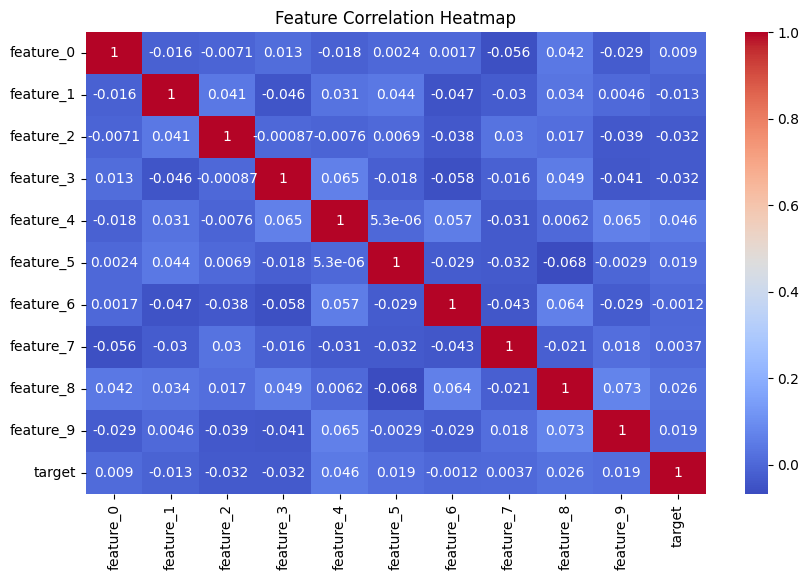

In [ ]:
#EDA
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
#SPLITING DATA
X_train, X_test, y_train, y_test=train_test_split(X_scaled, y, test_size=0.2, random_state=42)


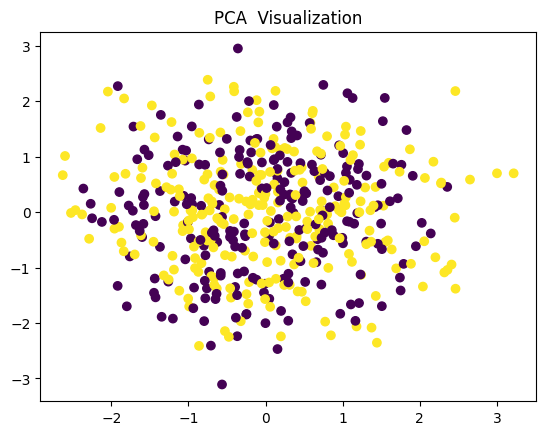

In [ ]:
#PCA
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X_scaled)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="viridis")
plt.title("PCA  Visualization")
plt.show()

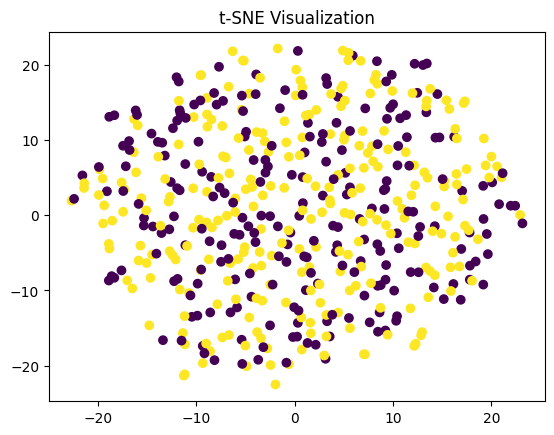

In [ ]:
# t-SNE
tsne=TSNE(n_components=2, random_state=42)
X_tsne=tsne.fit_transform(X_scaled)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap="viridis")
plt.title("t-SNE Visualization")
plt.show()

In [ ]:
# Model Train
model=RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Hyperparameter tuning
param_grid = {'n_estimators': [50,100,200],'max_depth': [None, 10, 20]}
grid_search=GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best GridSearchCV Params:",grid_search.best_params_)

Best GridSearchCV Params: {'max_depth': None, 'n_estimators': 50}


In [ ]:
random_search=RandomizedSearchCV(model, param_grid, cv=5,n_iter=5, random_state=42, scoring='accuracy')
random_search.fit(X_train, y_train)
print("Best RandomizedSearchCV Params:",random_search.best_params_)

Best RandomizedSearchCV Params: {'n_estimators': 100, 'max_depth': 20}


In [ ]:
bayesian_search=BayesSearchCV(model, param_grid, cv=5, n_iter=5, random_state=42, scoring='accuracy')
bayesian_search.fit(X_train, y_train)
print("Best Bayesian Optimization Params:",bayesian_search.best_params_)

Best Bayesian Optimization Params: OrderedDict([('max_depth', 10), ('n_estimators', 200)])


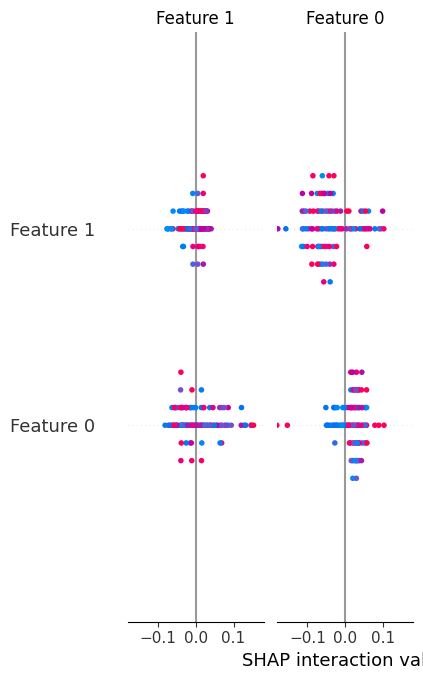

In [ ]:
#Model interpretability with SHAP
explainer=shap.Explainer(model, X_train)
shap_values=explainer (X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
#Model interpretability with lime
explainer=LimeTabularExplainer(X_train, mode='classification',training_labels=y_train)
instance= X_test[0]
exp = explainer.explain_instance(instance, model.predict_proba)
exp.show_in_notebook()